# Image Segmentation with K-Means Clustering

## Initial Setup

In [1]:
# Libraries used in this project
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
import random

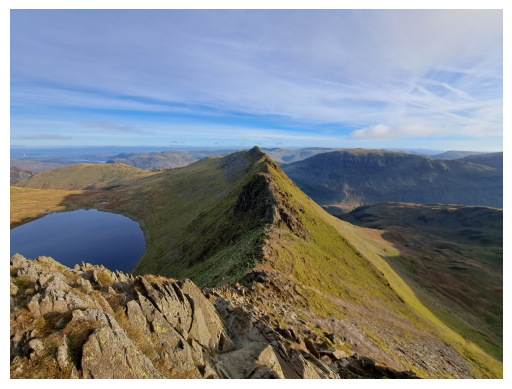

In [2]:
# importing an image
def import_image(filename):
    
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # swap colour channels so that it is displayed correctly

    return img


img = import_image("helvellyn.jpg");
plt.axis('off')
plt.imshow(img);

## Plotting Pixel Data in 3D Space

Below is a demonstration of the apparent clusters that form when plotting pixel data in 3D space. Similar colour pixels will be plotted near each other. Therefore high density areas of the graph indicate that there is a large number of similar pixles thgroughout the image.

240000 total pixels, only 4800.0 are shown


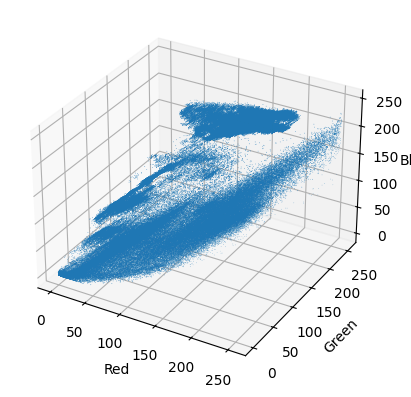

In [19]:
# APPROXIMATE RUN TIME: 5-10 SECONDS (depending on device)

img = import_image("helvellyn.jpg");

# split up colour channels
r, g, b = cv2.split(img)

# reformat pixel colours into [1 x num_pixels] array
r = r.flatten()[1::50] # take every 50th value from the array
g = g.flatten()[1::50]
b = b.flatten()[1::50]

print(f"{len(r)} total pixels, only {len(r)/50} are shown")

# show on scatter plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(r, g, b, s=0.3, linewidths=0)
ax.set_xlabel("Red")
ax.set_ylabel("Green")
ax.set_zlabel("Blue")

plt.savefig("pixels_in_3d_space.png", format="png", dpi=600)

## K-Means Classification (Simple Version)

dimensions: (267, 400, 3)


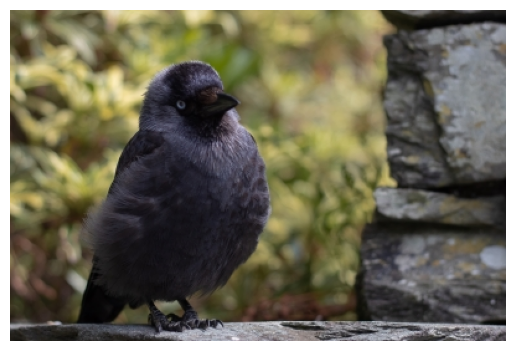

In [31]:
# setup

img = import_image("bird-small.jpg")
plt.axis('off')
plt.imshow(img);

print(f"dimensions: {img.shape}")

# split into channels
r, g, b = cv2.split(img)

# reformat pixel colours into 1xn array
r = np.array(r.flatten())
g = np.array(g.flatten())
b = np.array(b.flatten())


In [32]:
# ESTIMATED RUN TIME: 30 SECONDS

# define initial cluster centres

# euclidean distance
def dist(a, b):
    return np.sqrt( (a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2 )


# number of clusters/centroids
k = 4

# random initial starting points within range 0, 255
centroids = np.array([ [random.randint(0, 255),
                        random.randint(0, 255),
                        random.randint(0, 255)] for i in range(k)])

# number of pixels in the image
pixels = len(r)

# exit conditions - stop repeating when max iterations have been reached
# or the centroids stop moving
max_iter = 8
moved = True


# MAIN

iter = 0 

while moved and iter <= max_iter:
    iter += 1
    
    # cluster assignments, placeholder array
    assignment = [0]*pixels

    # for each pixel
    for i in range(pixels):

        # compute distance between each pixel and each centroid
        distances = [0]*k
        for j in range(k):
            distances[j] = dist(centroids[j], [r[i], g[i], b[i]] )

        
        # find minimum distance, returns index (0, .., k-1) of nearest centroid
        nearest = np.argmin(distances)
        
        
        # will look something like:
        #     [0, 0, 1, 0, 1, 2, 2, 0, ...]
        # with a centroid value assigned to each pixel
        assignment[i] = nearest
        
    prev_centroids = centroids.copy()
    
    # for each cluster, calculate mean of allocated points for each dimension
    for i in range(k):

        # list of array indices of pixels that belong to each cluster
        ind = [j for j in range(pixels) if assignment[j] == i ]

        # check cluster assignment is not empty
        # prevents divide by zero error when calculating mean
        if len(ind) != 0:
            centroids[i][0] = np.mean(r[ind])
            centroids[i][1] = np.mean(g[ind])
            centroids[i][2] = np.mean(b[ind])
        else: 
            centroids[i][0] = 0
            centroids[i][1] = 0
            centroids[i][2] = 0
    
    # check if centroids have moved
    if np.array_equal(centroids, prev_centroids):
        moved = False


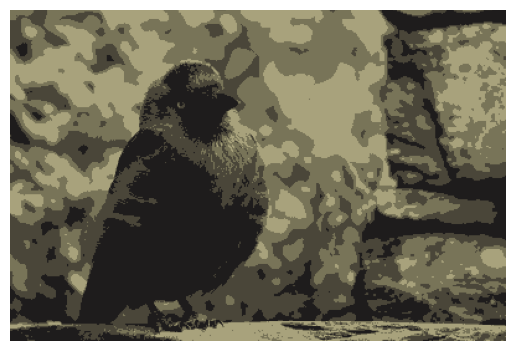

In [33]:
# display clustered image

# make copy of colour channels
r_copy = np.array(r.copy())
g_copy = np.array(g.copy())
b_copy = np.array(b.copy())

# update pixels to be the colour of their cluster
for i in range(k):
    ind = [j for j in range(pixels) if assignment[j] == i ]

    r_copy[ind] = centroids[i][0]
    g_copy[ind] = centroids[i][1]
    b_copy[ind] = centroids[i][2]

# compile channels
img2 = np.array([r_copy, g_copy, b_copy])

# transpose to group values into pixels
img2 = img2.transpose()

# reshape list of pixels into height x widgh x channels
img2 = img2.reshape(img.shape)

plt.axis('off')
plt.imshow(img2)

plt.savefig("bird-small(k4).png", format="png", dpi=600)


## K-Means Classification (Optimised Version)

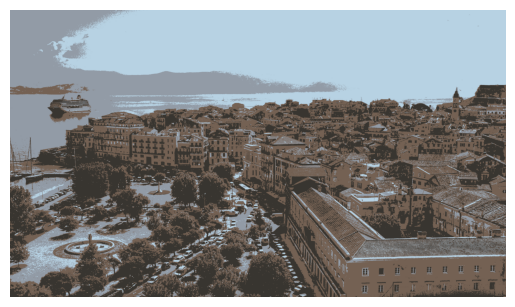

In [49]:
# ESTIMATED RUN TIME - depends on size of image - if using images supplied with this notebook, around 30-45 seconds depending 
# on value of k chosen. Higher values take longer to run.

img = import_image("corfu.jpg")

# split image into channels, reformat h x w x c structure 
img = np.array(cv2.split(img))
img = img.transpose(1, 2, 0)

# exit conditions
max_iter = 10
moved = True

# number of clusters
k = 4

# initial cluster centres
clusters = [[random.randint(0, 255) for i in range(3)] for j in range(k) ]

# define distance function
def euclidean_distance(a, b):
    return (np.sqrt(np.sum( (b-a)**2, 2)))

# main

iter = 0
while iter <= max_iter and moved == True:
    iter += 1

    # calculate distance between pixels and cluster, for every cluster
    distances = [euclidean_distance(img, clusters[i]) for i in range(k)]        

    # index (0, ..., k) of the nearest cluster centre for each pixel
    # produces an array the same shape as the image, instead of pixels,
    # it stores in the index of the nearest cluster
    # this can be used as a mask later on
    nearest = np.argmin(distances, 0) 

    prev_clusters = clusters.copy()
    
    for i in range(k):
        
        # create 1-hot encoded mask of which pixels belong to the cluster
        ind = np.array( np.where(nearest == i, 1, 0), dtype = bool) 

        # apply mask to image to extract subset of pixels 
        subset = img[ind] 

         # calculate mean of the identified subset - update cluster centres
        clusters[i] = [np.round(np.mean(subset[:,0])), np.round(np.mean(subset[:,1])), np.round(np.mean(subset[:,2]))]

        # remove NaN values - replace with 0
        if np.isnan(clusters[i][0]):
            clusters[i][0] = 0
        if np.isnan(clusters[i][1]):
            clusters[i][1] = 0
        if np.isnan(clusters[i][2]):
            clusters[i][2] = 0

    if clusters == prev_clusters:
        moved = False
    

# after the final iteration, the cluster centres represent the pixel colour of each cluster
# we apply the final version of the array, nearest, as a mask to sample colours for each pixel

clusters = np.array(clusters, dtype = int)
img2 = clusters[nearest]

# display image
plt.axis('off')
plt.imshow(img2)

plt.savefig("corfu(k4).png", format="png", dpi=600)

# this may produce warnings if there is an empty cluster (doesn't cause errors, since the NaN values are caught)

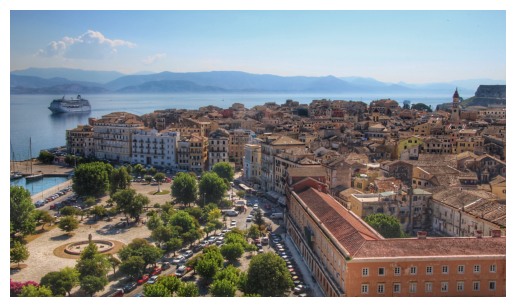

In [51]:
plt.axis('off')
plt.imshow(img);